<a href="https://colab.research.google.com/github/AmadeuAnjos/IniciacaoCientifica-Lung/blob/main/COVID_19_Lung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação das bibliotecas

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import numpy as np
tf.__version__

'2.5.0'

# Carregamento da base de dados


Abaixo fazemos a conexão com o Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Abaixo descompactamos o arquivo puxado do Google Drive, extraimos e fechamos o zipfile.

In [ ]:
path = "/content/drive/My Drive/dataset.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
zip_object.close()

Abaixo carregamos duas imagens, uma de um pulmão com covid-19 e outra um pouco mais abaixo um pulmão saudável. utilizamos o tamanho de imagem 224x224.

In [102]:
image = tf.keras.preprocessing.image.load_img(r'/content/covid_dataset/covid/COVID-10.png', target_size=(224,224))

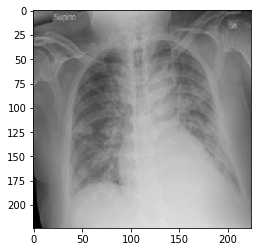

In [103]:
plt.imshow(image);

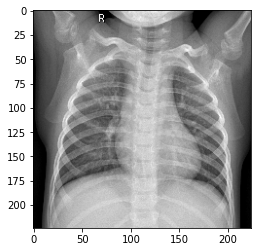

In [105]:
image = tf.keras.preprocessing.image.load_img(r'/content/covid_dataset/normal/IM-0678-0001.jpeg', target_size=(224, 224))
plt.imshow(image);

# Criando a base de dados treino

Abaixo transformamos as imagens para o formato do TensorFlow.

Usamos o ImageDataGenerator para gerar imagens a partir das imagens que temos no dataset, rotacionamos para esquerda, para a direita, damos zoom, diminuimos para que tenhamos mais imagens.

In [107]:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
                                   rotation_range = 50,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   vertical_flip = True)

Abaixo buscamos as imagens do diretório para treinamento e passamos os parâmetros de tamanho de imagem que será utilizados '224x224', passamos o 'batch_size=16' que será o tamanho do grupo de imagens que será utilizados para treinamento, usamos o parâmetro 'categorical' que é para classificar as imagens e 'shuffle = True' que é para pegar imagens aleatórias.

In [108]:
train_generator = train_datagen.flow_from_directory('/content/covid_dataset/train',
                                                    target_size = (224, 224),
                                                    batch_size=16,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

Found 667 images belonging to 2 classes.


Abaixo é retornado a quantidade de imagens encontradas.

In [109]:
train_generator.n

667

Abaixo é retornado o tamanho do grupo de imagens.

In [110]:
train_generator.batch_size

16

Abaixo é dividido a quantidade de imagens encontradas pelo grupo de imagens que foram treinadas.

In [111]:
step_size_train = train_generator.n // train_generator.batch_size
step_size_train

41

# Criando a base de dados teste

Abaixo usamos novamente o ImageDataGenerator, mas diferente do treino, pois usamos imagens originais para teste.

In [112]:
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

Abaixo buscamos as imagens para teste do diretório com os parâmetros; tamanho da imagem, tamanho do grupo que será treinado, modo categorical que classifica as imagens e o shuffle para testar imagens aleatórias.

In [113]:
test_generator = test_datagen.flow_from_directory('/content/covid_dataset/test',
                                                  target_size=(224,244),
                                                  batch_size=1,
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 149 images belonging to 2 classes.


Abaixo é dividido a quantidade de imagens encontradas pelo grupo de imagens que foram testadas.

In [114]:
step_size_test = test_generator.n // test_generator.batch_size
step_size_test

149

## Construção do modelo a partir da técnica Transfer Learning

Abaixo carregamos a arquitetura ResNet50, passamos o 'weights='imagenet' que é uma base de dados já treinada, assim elimina uma construção do zero. Passamos o parâmetro 'include_top=False' que elimina a classificação das imagens e carrega apenas a parte convolucional.

In [115]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)

Abaixo com o parâmetro 'sumary' é carregado todas as camadas da rede neural.

In [116]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Abaixo carregamos a última camada da rede neural.

In [117]:
x = base_model.output

Abaixo aplicamos 'GlobalAveragePooling2D()' reduzindo a dimensionalidade dos dados e tirando a média da variável 'x' que recebe a última camada convulocional.

In [118]:
x = tf.keras.layers.GlobalAveragePooling2D()(x)

Abaixo carregamos o modelo base com uma série de camadas densas.
Primeiramente usamos uma estrutura com 1024 neurônios e função de ativação 'relu' e ligamos a variável 'x' logo acima. 
Usamos uma camada após outra e vamos diminuindo os neurônios até chegar em 
2 neurônios, devido a ser uma classificação binária, onde temos apenas duas saidas que é a imagem do pulmão saudável e a outra do pulmão infectado pelo COVID-19.



In [119]:
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
preds = tf.keras.layers.Dense(2, activation='softmax')(x)

Abaixo definimos o 'model' criando nossa rede neural completa.
indicamos que o modelo base atráves da entrada 'input' e relacionamos a saída com o 'preds' que está referenciamos como previsões.

In [120]:
model = tf.keras.Model(inputs = base_model.input, outputs = preds)

Abaixo visualisamos o 'sumary()'.

In [121]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Abaixo utilizamos o 'enumerate' para percorrer todas as camadas, e o 'i' para começar no índice '0'.
Do índice '0' ao '174' usamos os pesos da arquitetura no 'imagenet' que já estão treinados, do índice '175' ao '179' incrementamos as camadas densas para obter um melhor resultado no treinamento.


In [122]:
for i, layer in enumerate(model.layers):
  print(i, layer.name)

0 input_2
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

Abaixo fazemos o 'for' para congelar o índice do '0' até o '174'. para que possa ser treinado as próximas camadas.

In [123]:
for layer in model.layers[:175]:
  layer.trainable = False  

Abaixo fazemos outro 'for' para que seja treinado apartir do índice '175'.

In [124]:
for layer in model.layers[175:]:
  layer.trainable = True  

Abaixo usamos o otimizador 'Adam' que é um dos mais utilizados, pois demonstram melhores resultados.
'loss' para calcular o erro.
'metrics' para verificar a acurácia do nosso otimizador.

In [125]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

Abaixo utilizamos o 'model.fit_generator' pelo fato de anteriormente usarmos o gerador de imagens, iremos treinar por 15 épocas, passar o valor da variável 'step_size_train' que tem valor de '41' e validamos na base de dados 'teste' cujo a variável 'step_size_test' tem valor de '9'.

In [126]:
history = model.fit_generator(generator=train_generator,
                              epochs=10,
                              steps_per_epoch=step_size_train,
                              validation_data = test_generator,
                              validation_steps=step_size_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
41/41 [==============================] - 25s 537ms/step - loss: 0.2345 - accuracy: 0.9401 - val_loss: 0.0135 - val_accuracy: 0.9933
Epoch 2/10
41/41 [==============================] - 21s 516ms/step - loss: 0.1073 - accuracy: 0.9631 - val_loss: 0.1769 - val_accuracy: 0.9262
Epoch 3/10
41/41 [==============================] - 21s 521ms/step - loss: 0.0241 - accuracy: 0.9923 - val_loss: 0.2951 - val_accuracy: 0.9396
Epoch 4/10
41/41 [==============================] - 21s 520ms/step - loss: 0.0100 - accuracy: 0.9969 - val_loss: 0.0141 - val_accuracy: 0.9933
Epoch 5/10
41/41 [==============================] - 21s 518ms/step - loss: 0.0328 - accuracy: 0.9908 - val_loss: 0.0653 - val_accuracy: 0.9664
Epoch 6/10
41/41 [==============================] - 21s 520ms/step - loss: 0.0280 - accuracy: 0.9923 - val_loss: 0.0115 - val_accuracy: 0.9933
Epoch 7/10
41/41 [==============================] - 21s 517ms/step - loss: 0.0328 - accuracy: 0.9877 - val_loss: 0.0643 - val_accuracy: 0.9732

# Avaliação dos resultados.

Abaixo usamos o comando do numpy 'np.mean' para mostrar a média da variável 'val_accuracy', que por sua vez mostra a acurácia de acertos na base de dados de teste.

In [127]:
np.mean(history.history['val_accuracy'])

0.9697986543178558

Abaixo usamos o comando numpy 'np.std' para mostrar o desvio padrão.

In [128]:
np.std(history.history['val_accuracy'])

0.02461357783359192

Abaixo puxamos o histórico da variável 'loss' que é o erro na base de dados de treinamento e também puxamos o histórico de erro da variável 'val_loss' que é o erro na base de dados de treinamento.
Preenchemos com os seguintes atributos para caracterizar o gráfico:
##Título = 'Loss'
##Eixo Y = 'Loss'
##Eixo X = 'Epoch'



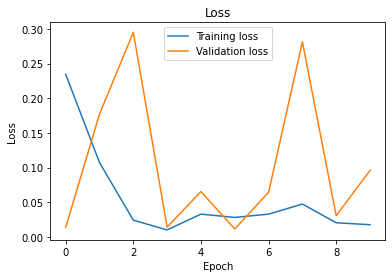

In [129]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend();

Abaixo puxamos o histórico da variável 'accuracy' que é a acurácia da base de dados de treinamento e puxamos o histórico da variável 'val_accuracy' que é a acurácia da base de dados de teste.
Preenchemos com os seguintes atributos para caracterizar o gráfico:
##Título = 'Accuracy'
##Eixo Y = 'Accuracy'
##Eixo X = 'Epoch'

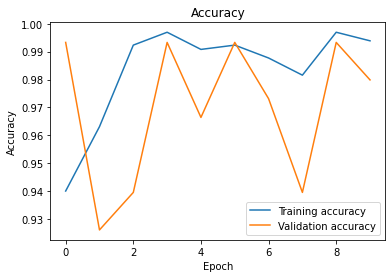

In [130]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend();

## Previsões

Abaixo faremos as previsões.

Criamos uma pasta com o nome 'filenames' e jogamos as imagens da base de dados de teste dentro dela e listamos.

In [131]:
filenames = test_generator.filenames
filenames

['covid/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg',
 'covid/1-s2.0-S0140673620303706-fx1_lrg.jpg',
 'covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg',
 'covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg',
 'covid/1-s2.0-S0929664620300449-gr2_lrg-c.jpg',
 'covid/1-s2.0-S0929664620300449-gr2_lrg-d.jpg',
 'covid/1-s2.0-S1684118220300608-main.pdf-001.jpg',
 'covid/1-s2.0-S1684118220300608-main.pdf-002.jpg',
 'covid/1-s2.0-S1684118220300682-main.pdf-002-a1.png',
 'covid/1-s2.0-S1684118220300682-main.pdf-002-a2.png',
 'covid/1B734A89-A1BF-49A8-A1D3-66FAFA4FAC5D.jpeg',
 'covid/E63574A7-4188-4C8D-8D17-9D67A18A1AFA.jpeg',
 'covid/F2DE909F-E19C-4900-92F5-8F435B031AC6.jpeg',
 'covid/F4341CE7-73C9-45C6-99C8-8567A5484B63.jpeg',
 'covid/F63AB6CE-1968-4154-A70F-913AF154F53D.jpeg',
 'covid/FE9F9A5D-2830-46F9-851B-1FF4534959BE.jpeg',
 'covid/gr1_lrg-a.jpg',
 'covid/gr1_lrg-b.jpg',
 'covid/kjr-21-e24-g001-l-a.jpg',
 'covid/kjr-21-e24-g002-l-a.jpg',
 'covid/kjr-21-e24-g003-l-a.jpg',
 'covid/kjr-21-e25-g001-l-a.j

Abaixo é retornado a quantidade total de imagens na pasta.

In [132]:
len(filenames)

149

Abaixo criamos a variável 'predictions' que são as previsões, passamos como paramêtro uma pasta com as imagens e passamos a quantidade de imagens que devem ser feita as previsões, sendo 149 imagens.

In [133]:
predictions = model.predict_generator(test_generator, steps = len(filenames))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Abaixo é retornado um array de probabilidade das duas variáveis que são 'covid-19' e 'normal'.

In [134]:
predictions

array([[1.00000000e+00, 3.12453119e-11],
       [9.73877072e-01, 2.61229239e-02],
       [9.99999881e-01, 8.56197531e-08],
       [1.00000000e+00, 4.19559072e-08],
       [9.99999881e-01, 1.57039395e-07],
       [1.00000000e+00, 4.62942324e-08],
       [9.99999762e-01, 2.58308916e-07],
       [9.99590218e-01, 4.09767032e-04],
       [1.00000000e+00, 9.08515219e-09],
       [3.01318406e-03, 9.96986806e-01],
       [1.00000000e+00, 8.94869734e-10],
       [9.99991179e-01, 8.79777690e-06],
       [9.99211669e-01, 7.88252742e-04],
       [9.99982595e-01, 1.74164434e-05],
       [1.00000000e+00, 5.39443924e-13],
       [1.00000000e+00, 3.65379393e-09],
       [9.99999404e-01, 6.22507969e-07],
       [9.97857988e-01, 2.14195135e-03],
       [9.99982238e-01, 1.77307029e-05],
       [1.00000000e+00, 2.28585471e-08],
       [7.99281120e-01, 2.00718865e-01],
       [2.83099082e-03, 9.97169077e-01],
       [9.99975920e-01, 2.41044509e-05],
       [1.13450609e-01, 8.86549354e-01],
       [1.000000

Abaixo mostramos a quantidade de imagens que foram feitas as previsões.

In [135]:
len(predictions)

149

Abaixo criamos uma variável 'predictions2' que será uma lista, através do 'for' percorremos toda essa lista e com o Numpy encontramos o índice onde se encontra o maior valor dessa lista.

In [136]:
predictions2 = []
for i in range(len(predictions)):
  predictions2.append(np.argmax(predictions[i]))

Abaixo vamos visualizar as previsões.


In [137]:
predictions2

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

Abaixo trazemos a classe generator que contém seus valores reais, comparando com as previsões acima temos um bom resultado.

In [138]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Abaixo fazemos mostramos qual é a label da covid e o normal.

In [139]:
test_generator.class_indices

{'covid': 0, 'normal': 1}

Abaixo faremos o cálculo da acurácia.

In [140]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(predictions2, test_generator.classes)

0.9798657718120806

Abaixo visualizamos a matriz 'confusion_matrix'.

In [141]:
cm = confusion_matrix(predictions2, test_generator.classes)
cm

array([[ 25,   0],
       [  3, 121]])

Abaixo visualizamos essa matriz graficamente.

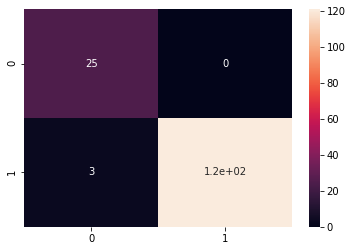

In [142]:
sns.heatmap(cm, annot=True);

## Testando as imagens.

Abaixo carregamos a primeira imagem do pulmão com covid-19 para testarmos.

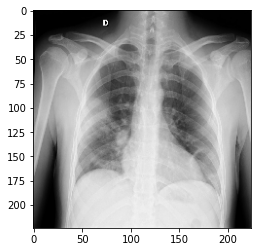

In [144]:
image = tf.keras.preprocessing.image.load_img(r'/content/covid_dataset/covid/CD50BA96-6982-4C80-AE7B-5F67ACDBFA56.jpeg', target_size=(224,224))
plt.imshow(image);

Abaixo visualizamos o tipo de imagem.

In [145]:
type(image)

PIL.Image.Image

Precisamos passar essa imagem para o formato do 'TensorFlow'.
Primeiramente vamos coloca-lá em um array.
com o método 'np.shape' é demonstrado o tamanho da imagem 224 x 224 e o '3' está informando que a imagem está em escala RGB (Red, Green e Blue).

In [146]:
image = tf.keras.preprocessing.image.img_to_array(image)
np.shape(image)

(224, 224, 3)

Abaixo visualizamos novamente, mas desta vez está em formato Numpy array.

In [147]:
type(image)

numpy.ndarray

Abaixo visualizamos o valor máximo e mínimo de pixel existente nessa imagem.

In [148]:
np.max(image), np.min(image)

(255.0, 0.0)

Abaixo fazemos mais um processo, expandindo as dimensões da imagem e convertendo para o formato do TensorFlow.

In [149]:
image = np.expand_dims(image, axis = 0)
np.shape(image)

(1, 224, 224, 3)

Abaixo fazemos o pré processamento dos pixels que foram criados a partir da arquitetura 'resnet50'.

In [150]:
image = tf.keras.applications.resnet50.preprocess_input(image)

Abaixo visualizamos o valor máximo e mínimo de pixel existente na imagem após o pré processamento.

In [151]:
np.max(image), np.min(image)

(151.061, -123.68)

Abaixo fazemos as previsões dessa imagem.

In [152]:
predictions = model.predict(image)
print(predictions)

[[0.99843305 0.00156688]]


Abaixo pegamos a previsão na posição '0' e é retornado um array.

In [153]:
predictions[0]

array([0.99843305, 0.00156688], dtype=float32)

Abaixo pegamos o índice com o maior valor, que é o índice '0'.

In [154]:
np.argmax(predictions[0])

0

Abaixo criamos uma lista com os índices.

In [155]:
list(train_generator.class_indices)

['covid', 'normal']

Abaixo fazemos a previsão desta imagem, se é uma imagem de pulmão com 'covid-19' ou um pulmão saudável 'normal'.

In [156]:
prediction = list(train_generator.class_indices)[np.argmax(predictions[0])]
prediction

'covid'

Abaixo carregamos a segunda imagem do pulmão com covid-19 para testarmos.

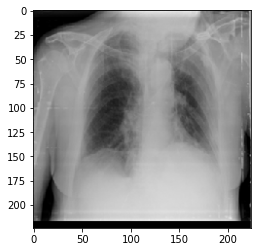

In [211]:
image = tf.keras.preprocessing.image.load_img(r'/content/covid_dataset/covid/COVID-1009.png', target_size=(224,224))
plt.imshow(image);

Abaixo visualizamos o tipo de imagem.

In [212]:
type(image)

PIL.Image.Image

Precisamos passar essa imagem para o formato do 'TensorFlow'.
Primeiramente vamos coloca-lá em um array.
com o método 'np.shape' é demonstrado o tamanho da imagem 224 x 224 e o '3' está informando que a imagem está em escala RGB (Red, Green e Blue).

In [213]:
image = tf.keras.preprocessing.image.img_to_array(image)
np.shape(image)

(224, 224, 3)

Abaixo visualizamos novamente, mas desta vez está em formato Numpy array.

In [214]:
type(image)

numpy.ndarray

Abaixo visualizamos o valor máximo e mínimo de pixel existente nessa imagem.

In [215]:
np.max(image), np.min(image)

(235.0, 0.0)

Abaixo fazemos mais um processo, expandindo as dimensões da imagem e convertendo para o formato do TensorFlow.

In [216]:
image = np.expand_dims(image, axis = 0)
np.shape(image)

(1, 224, 224, 3)

Abaixo fazemos o pré processamento dos pixels que foram criados a partir da arquitetura 'resnet50'.

In [217]:
image = tf.keras.applications.resnet50.preprocess_input(image)

Abaixo visualizamos o valor máximo e mínimo de pixel existente na imagem após o pré processamento.

In [218]:
np.max(image), np.min(image)

(131.061, -123.68)

Abaixo fazemos as previsões dessa imagem.

In [219]:
predictions = model.predict(image)
print(predictions)

[[9.999999e-01 7.313953e-08]]


Abaixo pegamos a previsão na posição '0' e é retornado um array.

In [220]:
predictions[0]

array([9.999999e-01, 7.313953e-08], dtype=float32)

Abaixo pegamos o índice com o maior valor, que é o índice '0'.

In [221]:
np.argmax(predictions[0])

0

Abaixo criamos uma lista com os índices.

In [222]:
list(train_generator.class_indices)

['covid', 'normal']

Abaixo fazemos a previsão desta imagem, se é uma imagem de pulmão com 'covid-19' ou um pulmão saudável 'normal'.

In [223]:
prediction = list(train_generator.class_indices)[np.argmax(predictions[0])]
prediction

'covid'

Abaixo carregamos a primeira imagem do pulmão saudável para testarmos.

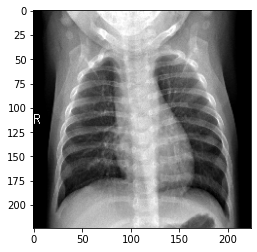

In [233]:
image = tf.keras.preprocessing.image.load_img(r'/content/covid_dataset/normal/NORMAL2-IM-0346-0001.jpeg', target_size=(224,224))
plt.imshow(image);

Abaixo visualizamos o tipo de imagem.

In [234]:
type(image3)

PIL.Image.Image

Precisamos passar essa imagem para o formato do 'TensorFlow'. Primeiramente vamos coloca-lá em um array. com o método 'np.shape' é demonstrado o tamanho da imagem 224 x 224 e o '3' está informando que a imagem está em escala RGB (Red, Green e Blue).

In [235]:
image = tf.keras.preprocessing.image.img_to_array(image)
np.shape(image)

(224, 224, 3)

Abaixo visualizamos novamente, mas desta vez está em formato Numpy array.

In [236]:
type(image)

numpy.ndarray

Abaixo visualizamos o valor máximo e mínimo de pixel existente nessa imagem.

In [237]:
np.max(image), np.min(image)

(255.0, 0.0)

Abaixo fazemos mais um processo, expandindo as dimensões da imagem e convertendo para o formato do TensorFlow.

In [238]:
image = np.expand_dims(image, axis = 0)
np.shape(image)

(1, 224, 224, 3)

Abaixo fazemos o pré processamento dos pixels que foram criados a partir da arquitetura 'resnet50'.

In [239]:
image = tf.keras.applications.resnet50.preprocess_input(image)

Abaixo visualizamos o valor máximo e mínimo de pixel existente na imagem após o pré processamento.

In [240]:
np.max(image), np.min(image)

(151.061, -123.68)

Abaixo fazemos as previsões dessa imagem.

In [241]:
predictions = model.predict(image)
print(predictions)

[[3.8920158e-14 1.0000000e+00]]


Abaixo pegamos a previsão na posição '0' e é retornado um array.

In [242]:
predictions[0]

array([3.8920158e-14, 1.0000000e+00], dtype=float32)

Abaixo pegamos o índice com o maior valor, que é o índice '0'.

In [243]:
np.argmax(predictions[0])

1

Abaixo criamos uma lista com os índices.

In [244]:
list(train_generator.class_indices)

['covid', 'normal']

Abaixo fazemos a previsão desta imagem, se é uma imagem de pulmão com 'covid-19' ou um pulmão saudável 'normal'.

In [245]:
prediction = list(train_generator.class_indices)[np.argmax(predictions[0])]
prediction

'normal'

Abaixo carregamos a segunda imagem do pulmão saudável para testarmos.

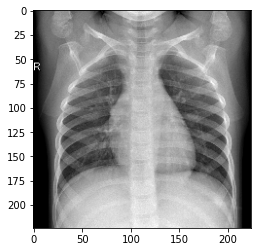

In [246]:
image = tf.keras.preprocessing.image.load_img(r'/content/covid_dataset/normal/NORMAL2-IM-0493-0001.jpeg', target_size=(224,224))
plt.imshow(image);

Abaixo visualizamos o tipo de imagem.

In [247]:
type(image)

PIL.Image.Image

Precisamos passar essa imagem para o formato do 'TensorFlow'. Primeiramente vamos coloca-lá em um array. com o método 'np.shape' é demonstrado o tamanho da imagem 224 x 224 e o '3' está informando que a imagem está em escala RGB (Red, Green e Blue).

In [248]:
image = tf.keras.preprocessing.image.img_to_array(image)
np.shape(image)

(224, 224, 3)

Abaixo visualizamos novamente, mas desta vez está em formato Numpy array.

In [249]:
type(image)

numpy.ndarray

Abaixo visualizamos o valor máximo e mínimo de pixel existente nessa imagem.

In [250]:
np.max(image), np.min(image)

(255.0, 0.0)

Abaixo fazemos mais um processo, expandindo as dimensões da imagem e convertendo para o formato do TensorFlow.

In [251]:
image = np.expand_dims(image, axis = 0)
np.shape(image)

(1, 224, 224, 3)

Abaixo fazemos o pré processamento dos pixels que foram criados a partir da arquitetura 'resnet50'.

In [252]:
image = tf.keras.applications.resnet50.preprocess_input(image)

Abaixo visualizamos o valor máximo e mínimo de pixel existente na imagem após o pré processamento.

In [253]:
np.max(image), np.min(image)

(151.061, -123.68)

Abaixo fazemos as previsões dessa imagem.

In [254]:
predictions = model.predict(image)
print(predictions)

[[6.4135514e-16 1.0000000e+00]]


Abaixo pegamos a previsão na posição '0' e é retornado um array.

In [255]:
predictions[0]

array([6.4135514e-16, 1.0000000e+00], dtype=float32)

Abaixo pegamos o índice com o maior valor, que é o índice '0'.

In [256]:
np.argmax(predictions[0])

1

Abaixo criamos uma lista com os índices.

In [257]:
list(train_generator.class_indices)

['covid', 'normal']

Abaixo fazemos a previsão desta imagem, se é uma imagem de pulmão com 'covid-19' ou um pulmão saudável 'normal'.

In [258]:
prediction = list(train_generator.class_indices)[np.argmax(predictions[0])]
prediction

'normal'